<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/ip_practice11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Image Processing Practice 11__

1. Definition a Convolutional Neural Network
2. Datasets and DataLoaders
3. Training and Validation Functions
4. Main loop
5. Confusion Matrix

-------------------------------
## 0. Preparations

In [ ]:
!pip3 install torch torchvision tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Checking PyTorch and CUDA

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

!nvcc --version

Device: cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


---------------------------
## __1. Definition of a Convolutional Network__

In [ ]:
import numpy as np
import torch
import torch.nn as nn


class Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None):
    super().__init__()
    padding = padding or kernel_size//2

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.relu = nn.ReLU()
    self.bn = nn.BatchNorm2d(num_features=out_channels)

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.bn(x)

    return x


class ConvNet(nn.Module):
  def __init__(self, planes, num_classes=10):
    super().__init__()

    self.conv1 = Conv(in_channels=3, out_channels=planes)
    self.pool1 = Conv(in_channels=planes, out_channels=2*planes, stride=2)

    self.conv2 = Conv(in_channels=2*planes, out_channels=2*planes)
    self.pool2 = Conv(in_channels=2*planes, out_channels=4*planes, stride=2)

    self.conv3 = Conv(in_channels=4*planes, out_channels=4*planes)
    self.pool3 = Conv(in_channels=4*planes, out_channels=8*planes, stride=2)

    self.conv4 = Conv(in_channels=8*planes, out_channels=8*planes)
    self.pool4 = Conv(in_channels=8*planes, out_channels=16*planes, stride=2)

    self.conv5 = Conv(in_channels=16*planes, out_channels=16*planes)
    self.pool5 = Conv(in_channels=16*planes, out_channels=32*planes, stride=2)

    self.classifier = nn.Conv2d(in_channels=32*planes, out_channels=10, kernel_size=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.pool3(x)

    x = self.conv4(x)
    x = self.pool4(x)

    x = self.conv5(x)
    x = self.pool5(x)

    x = self.classifier(x).squeeze()

    return x

In [ ]:
x = torch.ones(2, 3, 32, 32)

model = ConvNet(planes=4)

with torch.no_grad():
  print(model(x).shape)

torch.Size([2, 10])


-----------------
## __2. Datasets and DataLoaders__


### Data Transforms

In [ ]:
import torchvision
from torchvision.transforms import v2


train_transforms = v2.Compose([
    v2.RandomCrop((32, 32), padding=4),
    v2.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
])

val_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
])

### Datasets

In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset, DataLoader


train_set = CIFAR10(root=".",
                    train=True,
                    transform=train_transforms,
                    target_transform=torch.tensor,
                    download=True)

val_set = CIFAR10(root=".",
                  train=False,
                  transform=val_transforms,
                  target_transform=torch.tensor,
                  download=True)

100%|██████████| 170M/170M [00:04<00:00, 40.0MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


### DataLoaders

In [ ]:
train_loader = DataLoader(dataset=train_set,
                          batch_size=512,
                          num_workers=2,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_set,
                          batch_size=500,
                          num_workers=2)

----------------------
## __3. Training and Validation Functions__

### Training

In [ ]:
def train(model, loss_fn, dataloader, optimizer, scheduler):
  train_loss, train_corr = 0.0, 0.0

  model.train()
  for i, (x, y_true) in enumerate(dataloader):
    scheduler.step()
    optimizer.zero_grad()
    x, y_true = x.to(device), y_true.to(device)

    y_pred = model(x)
    loss = loss_fn(y_pred, y_true)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    corrects = (torch.argmax(y_pred, dim=-1) == y_true).float().mean()*100
    train_corr += corrects.item()

  train_loss = train_loss / len(dataloader)
  train_corr = train_corr / len(dataloader)

  return train_loss, train_corr

### Validation

In [ ]:
def validate(model, loss_fn, dataloader):
  val_loss, val_corr = 0.0, 0.0

  model.eval()
  with torch.no_grad():
    for i, (x, y_true) in enumerate(dataloader):
      x, y_true = x.to(device), y_true.to(device)

      y_pred = model(x)
      loss = loss_fn(y_pred, y_true)

      val_loss += loss.item()
      corrects = (torch.argmax(y_pred, dim=-1) == y_true).float().mean()*100
      val_corr += corrects.item()

  val_loss = val_loss / len(dataloader)
  val_corr = val_corr / len(dataloader)

  return val_loss, val_corr

## Learning rate scheduler

In [ ]:
class LinearWarmupCosineAnnealScheduler():
  def __init__(self, optimizer, num_iters, warmup_iters, min_lr, max_lr):
    self.optimizer = optimizer
    self.num_iters = num_iters
    self.warmup_iters = warmup_iters
    self.min_lr = min_lr
    self.max_lr = max_lr
    self.lr_range = max_lr-min_lr

    self.iter = 0

  def step(self):
    if self.iter < self.warmup_iters:
      lr = self.min_lr + self.lr_range*self.iter/self.warmup_iters
    else:
      phase = (self.iter-self.warmup_iters)/(self.num_iters-self.warmup_iters)
      lr = (self.max_lr-0.5*self.lr_range) + (0.5*self.lr_range)*torch.cos(torch.pi*torch.tensor(phase))

    for param_group in self.optimizer.param_groups:
      if "lr_scale" in param_group:
        param_group["lr"] = lr * param_group["lr_scale"]
      else:
        param_group["lr"] = lr

    self.iter += 1

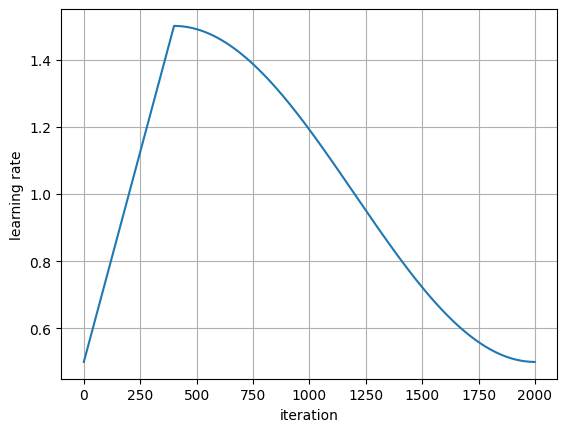

In [ ]:
import matplotlib.pyplot as plt


class MockOptimizer:
  def __init__(self):
    self.param_groups = [dict(lr=0, lr_scale=1)]

mock_optimizer = MockOptimizer()
scheduler = LinearWarmupCosineAnnealScheduler(optimizer=mock_optimizer,
                                              num_iters=20*100,
                                              warmup_iters=4*100,
                                              min_lr=0.5,
                                              max_lr=1.5)

lrs = []
for i in range(20):
  for j in range(100):
    scheduler.step()
    lrs.append(mock_optimizer.param_groups[0]["lr"])

plt.plot(lrs)
plt.xlabel("iteration")
plt.ylabel("learning rate")
plt.grid(True)
plt.show()

---------------
## __4. Main loop__

In [ ]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler


MB = 1024**2

# Hyperparameters
lr = 1e-2
num_epochs = 40
warmup_epochs = 8

model = ConvNet(planes=4)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
scheduler = LinearWarmupCosineAnnealScheduler(optimizer=optimizer,
                                              num_iters=num_epochs*len(train_loader),
                                              warmup_iters=warmup_epochs*len(train_loader),
                                              min_lr=0,
                                              max_lr=lr)

loss_fn = nn.CrossEntropyLoss()

train_losses = []
train_corrs = []
val_losses = []
val_corrs = []
lrs = []
for epoch in trange(num_epochs):
  train_loss, train_corr = train(model, loss_fn, train_loader, optimizer, scheduler)
  val_loss, val_corr = validate(model, loss_fn, val_loader)

  print(f"Epoch: {epoch} \tTrain loss: {train_loss:.3f} correct: {train_corr:.2f}% \tVal loss: {val_loss:.3f} correct: {val_corr:.2f}% \tmemory: {torch.cuda.max_memory_allocated() / MB:.2f}")

  train_losses.append(train_loss)
  train_corrs.append(train_corr)
  val_losses.append(val_loss)
  val_corrs.append(val_corr)
  lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(train_corrs, label="Train")
plt.plot(val_corrs, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Corrects")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(lrs)
plt.xlabel("iteration")
plt.ylabel("learning rate")
plt.grid(True)
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 	Train loss: 2.121 correct: 21.58% 	Val loss: 1.778 correct: 34.49% 	memory: 49.21
Epoch: 1 	Train loss: 1.745 correct: 36.08% 	Val loss: 1.552 correct: 43.56% 	memory: 49.21
Epoch: 2 	Train loss: 1.595 correct: 41.70% 	Val loss: 1.402 correct: 48.86% 	memory: 49.21
Epoch: 3 	Train loss: 1.464 correct: 47.18% 	Val loss: 1.338 correct: 51.75% 	memory: 49.21
Epoch: 4 	Train loss: 1.352 correct: 51.54% 	Val loss: 1.230 correct: 55.52% 	memory: 49.21
Epoch: 5 	Train loss: 1.239 correct: 55.49% 	Val loss: 1.148 correct: 59.45% 	memory: 49.21
Epoch: 6 	Train loss: 1.175 correct: 57.89% 	Val loss: 1.093 correct: 61.41% 	memory: 49.21
Epoch: 7 	Train loss: 1.125 correct: 59.90% 	Val loss: 1.072 correct: 61.58% 	memory: 49.21
Epoch: 8 	Train loss: 1.067 correct: 62.13% 	Val loss: 0.965 correct: 65.78% 	memory: 49.21
Epoch: 9 	Train loss: 1.026 correct: 63.68% 	Val loss: 0.937 correct: 67.00% 	memory: 49.21
Epoch: 10 	Train loss: 0.983 correct: 65.21% 	Val loss: 0.907 correct: 68.27% 	m

---------------------
## __5. Confusion Matrix__

In [ ]:
for i, (x, y_true) in enumerate(val_loader):
  confusion = torch.tensor(10, 10)
  with torch.no_grad():
    x = x.to(device)
    y_pred = model(x)
    y_pred = y_pred.to("cpu")

  prediction = torch.argmax(y_pred, dim=-1)
  for j in range(len(prediction)):
    confusion_matrix[y_true[j], y_pred[j]] += 1

confusion = confusion / confusion.sum(dim=1, keepdim=True)

plt.imshow(confusion)
plt.show()

## Vizualizáció

In [ ]:
names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

# forward
with torch.no_grad():
  outputs = model(inputs)

_, predicted = torch.max(outputs, 1)

mean = torch.Tensor((0.49139968, 0.48215827, 0.44653124)).unsqueeze(1).unsqueeze(1)
std = torch.Tensor((0.24703233, 0.24348505, 0.26158768)).unsqueeze(1).unsqueeze(1)

f, axarr = plt.subplots(2, 4,figsize=(10, 5))

for i,(img,pred) in enumerate(zip(inputs,predicted)):
    img_rescaled = img.cpu() * std + mean
    pr = pred.cpu().item()
    name = names[pr]

    axarr[i//4,i%4].imshow(img_rescaled.permute(1,2,0))
    axarr[i//4,i%4].set_title(name)
    # Hide grid lines
    axarr[i//4,i%4].grid(False)
    # Hide axes ticks
    axarr[i//4,i%4].set_xticks([])
    axarr[i//4,i%4].set_yticks([])
    if i == 7:
        break

## _Extras_
### Modern architectures and Training Techniques_
- [Transformer architecture](https://arxiv.org/pdf/1706.03762)
- [ViT](https://arxiv.org/pdf/2010.11929)
- [Swin-Transformer](https://arxiv.org/pdf/2103.14030)
- [ConvNext](https://arxiv.org/pdf/2201.03545)
- [Masked autoencoders](https://arxiv.org/pdf/2111.06377)
- [Decoder Denoising Pretraining](https://arxiv.org/pdf/2205.11423)
### Special solutions for specific tasks
- [SAM2](https://ai.meta.com/sam2/)
- [DUSt3R](https://europe.naverlabs.com/research/publications/dust3r-geometric-3d-vision-made-easy/)
- [NeRF](https://www.matthewtancik.com/nerf), [another](https://phog.github.io/snerg/)
- [YOLO](https://docs.ultralytics.com/models/yolo11/)